# A simple example

As a simple example to illustrate the application of quantile regression neural networks, we consider a simple, 1-dimensional regression probelm with heteroscedastic uncertainty:

\begin{align}
y = \sin(x) + 0.1 \cdot \cos(x) \cdot \mathcal{N}(0, 1)
\end{align}

The code below generatesthe synthetic training data consisting of $10^7$ randomly sampled $x$ values and corresponding $y$ values.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import quantnn
import quantnn.plots
quantnn.plots.set_style()

Using TensorFlow backend.


In [2]:
n = 10_000_000
x = 2.0 * np.pi * np.random.random(size=n)
y = np.sin(x) + 1.0 * np.cos(x) * np.random.randn(n) 

### Displaying the training data

In [3]:
bins_x = np.linspace(0, 2 * np.pi, 201)
bins_y = np.linspace(-4, 4, 201)
x_img, y_img = np.meshgrid(bins_x, bins_y)
img, _, _ = np.histogram2d(x, y, bins=(bins_x, bins_y), density=True)

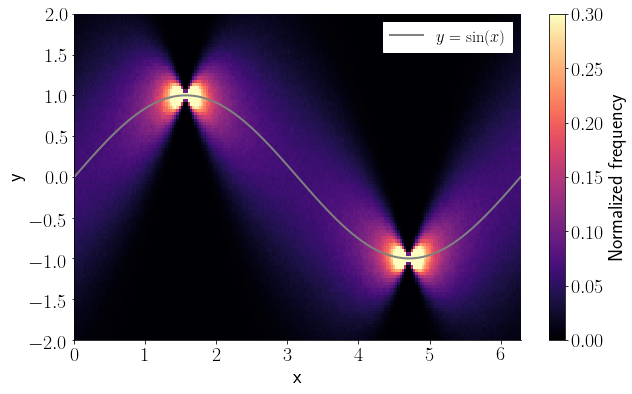

In [4]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))
m = ax.pcolormesh(x_img, y_img, img.T, vmin=0, vmax=0.3, cmap="magma")
x_sin = np.linspace(0, 2 * np.pi, 1001)
y_sin = np.sin(x_sin)
ax.plot(x_sin, y_sin, c="grey", label="$y=\sin(x)$")
ax.set_ylim([-2, 2])
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.colorbar(m, label="Normalized frequency");
plt.legend()

## Training the QRNN

A simple, fully-connected feed-forward neural network can be training on the data using the ``QRNN``. To create a QRNN model we need to specify the following information:

1. The number of input features, i.e. ``1``
2. A list of the quantiles that we want to predict (``quantiles``)
3. A tuple describing the model architecture ``(n_layers, n_neurons, activation_function)``

In [5]:
import quantnn as q
quantiles = [0.01, 0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95, 0.99]

layers = 4
neurons = 128
activation = "relu"
model = (layers, neurons, activation)
qrnn = q.QRNN(1, quantiles=quantiles, model=model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Finally we train the neural network on the training data. Here, we use only a subset of the data, in order to speed up the training process. We restart the training three times while lowering the learning rate, which leads to more accurate predicted quantiles.

In [6]:
training_data = (x[::10].reshape(-1, 1), y[::10].reshape(-1, 1))
qrnn.train(training_data=training_data,
           maximum_epochs=8,
           initial_learning_rate=0.1)
qrnn.train(training_data=training_data,
           maximum_epochs=4,
           initial_learning_rate=0.01)
qrnn.train(training_data=training_data,
           maximum_epochs=4,
           initial_learning_rate=0.001)


Epoch 1/8
3906/3906 [==============================] - 15s 4ms/step - loss: 2.2230
Epoch 2/8
3906/3906 [==============================] - 14s 4ms/step - loss: 2.1359
Epoch 3/8
3906/3906 [==============================] - 14s 4ms/step - loss: 2.1234
Epoch 4/8
3906/3906 [==============================] - 14s 4ms/step - loss: 2.1175
Epoch 5/8
3906/3906 [==============================] - 14s 4ms/step - loss: 2.1144
Epoch 6/8
3906/3906 [==============================] - 13s 3ms/step - loss: 2.1124
Epoch 7/8
3906/3906 [==============================] - 12s 3ms/step - loss: 2.1108
Epoch 8/8
3906/3906 [==============================] - 12s 3ms/step - loss: 2.1096
Epoch 1/4
3906/3906 [==============================] - 13s 3ms/step - loss: 2.0964
Epoch 2/4
3906/3906 [==============================] - 13s 3ms/step - loss: 2.0962
Epoch 3/4
3906/3906 [==============================] - 13s 3ms/step - loss: 2.0961
Epoch 4/4
3906/3906 [==============================] - 13s 3ms/step - loss: 2.0961
Epo

## Evaluation

To evaluate the QRNN we generate 1000 new $x$-value and use the ``predict`` method of the trained ``qrnn`` object to predict the quantiles of $y$.

In [7]:
n = 1_000
x_val = np.linspace(0, 2 * np.pi, n)
y_val = np.sin(x_val) + 1.0 * np.cos(x_val) * np.random.randn(n) 
y_pred = qrnn.predict(x_val.reshape(-1, 1))
y_mean = q.posterior_mean(y_pred, qrnn.quantiles)

To validate the predicted quantiles, we compare them to the empirical quantiles of the training data.

In [8]:
import scipy as sp
norm = np.trapz(img, x=0.5 * (bins_y[1:] + bins_y[:-1]), axis=1)
img_normed = img / norm.reshape(-1, 1)
img_cdf = sp.integrate.cumtrapz(img_normed, x=0.5 * (bins_y[1:] + bins_y[:-1]), axis=1)

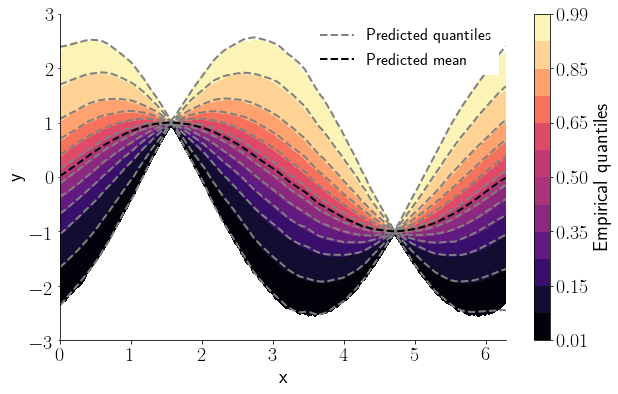

In [13]:
from matplotlib.cm import magma
x_centers = 0.5 * (bins_x[1:] + bins_x[:-1])
y_centers = 0.5 * (bins_y[2:] + bins_y[:-2])

plt.figure(figsize=(10, 6))
plt.contourf(x_centers, y_centers, img_cdf.T, levels=quantiles, cmap="magma",)
colors = magma(np.linspace(0.0, 1.0, 13))
for i in range(0, 13, 1):
    l_q = plt.plot(x_val, y_pred[:, i] , lw=2, ls="--", c="grey")[0]
l_m = plt.plot(x_val, y_mean, c="k", ls="--", lw=2)[0]
plt.legend(handles=[l_q, l_m], labels=["Predicted quantiles", "Predicted mean"])
plt.xlim([0, 2 * np.pi])
plt.ylim([-3, 3])
plt.xlabel("x")
plt.ylabel("y")
plt.grid(False)
plt.colorbar(label="Empirical quantiles")